# Import libraries
This imports necessary libraries and creates a helper method which we can use to initialize a new Spark Context with a certain configuration. We use this method to do benchmarks with different spark configurations (e.g. different number of cpu cores).

In [1]:
from stop_words import get_stop_words
import re
from pyspark import SparkContext, SparkConf

sparkContext = None
def createSparkContext(conf, sparkContext):
    if(sparkContext != None):
        sparkContext.stop()
    sparkContext = SparkContext(conf=conf) 
    return sparkContext

# Default Spark Context

In [2]:
conf = SparkConf().setMaster("local[2]")\
.setAll(
    [('spark.executor.memory', '4g'),\
     ('spark.app.name', 'Python Spark Count words'),\
     ('spark.executor.cores', '4'),\
     ('spark.cores.max', '4'),\
     ('spark.driver.memory','4g')])
sparkContext = sparkContext = SparkContext(conf=conf) 

# Count words
This is our method for counting words with Spark in several languages.

In [8]:
def analyzeFiles(sc, filePath):
    """
    Returns an dictionary with language as key and top 10 words as values
    """
    file = sc.wholeTextFiles(filePath)
    filesByLang = file.map(lambda x: (x[0].split("/")[-2], x[1])).reduceByKey(lambda v1,v2: v1+ " " + v2)
    wordsByLang = filesByLang.flatMapValues(lambda l: re.findall("\w+", l))

    preprocessedWords = wordsByLang.map(lambda x: (x[0], x[1].lower()))\
            .filter(lambda x: (x[1] not in get_stop_words(x[0].lower())))

    occurences = preprocessedWords.map(lambda w: ((w[0], w[1]), 1))\
            .reduceByKey(lambda v1,v2: v1+v2)
    occurencesPerLanguage = occurences.sortBy(lambda a: a[1], ascending=False)\
            .filter(lambda x: len(x[0][1]) != 1)\
            .map(lambda x: (x[0][0], (x[0][1], x[1])))\
            .groupByKey()
    
    occurencesPerLanguageCollected = occurencesPerLanguage.mapValues(list).collect()
    top10 = {}
    for languages in occurencesPerLanguageCollected:
        top10[languages[0]] = languages[1][:10]
    return top10

# Execute on test data

In [4]:
# Test data
print(analyzeFiles(sparkContext, "data/test/*/*.txt"))

{'German': [('test', 3), ('hallo', 2), ('neuer', 1), ('tolle', 1)], 'English': [('hey', 3), ('test', 1), ('never', 1), ('know', 1), ('say', 1), ('easy', 1)]}


# Real data

In [7]:
# real data
result = analyzeFiles(sparkContext, "data/texts/*/*.txt")

In [9]:
print(result)

{'English': [('said', 18368), ('one', 17930), ('will', 12828), ('upon', 12763), ('now', 11810), ('man', 11763), ('time', 9585), ('well', 9482), ('can', 8902), ('mr', 8743)], 'German': [('sagte', 10700), ('ja', 8849), ('schon', 7948), ('mehr', 7026), ('wurde', 6489), ('ganz', 6165), ('sah', 5858), ('rief', 5683), ('wohl', 5647), ('hand', 5610)], 'Russian': [('ним', 460), ('глаза', 298), ('друг', 273), ('сердце', 271), ('моей', 255), ('ночь', 241), ('жизни', 234), ('свой', 231), ('знаю', 224), ('горский', 224)], 'French': [('plus', 26737), ('dit', 22433), ('bien', 18336), ('homme', 10266), ('dont', 7398), ('rien', 7322), ('puis', 7193), ('monsieur', 7084), ('après', 6781), ('point', 6670)], 'Italian': [('disse', 8759), ('egli', 8691), ('poi', 7288), ('quel', 7199), ('quando', 6762), ('due', 6461), ('così', 6239), ('cosa', 5989), ('ora', 5809), ('ella', 5401)], 'Spanish': [('si', 5444), ('don', 3073), ('tan', 3026), ('dijo', 2992), ('usted', 2985), ('casa', 2451), ('bien', 2422), ('ser', 

# Benchmarks
We're creating different Spark Contexts configations and measure the execution time of the word count program. Afterwards we plot the results using seaborn.

In [3]:
import time

def executeAndMeasure(path, conf):
    print("Measure...")
    global sparkContext
    sparkContext = createSparkContext(conf, sparkContext)
    start = time.time()
    analyzeFiles(sparkContext, path)
    end = time.time()
    return end - start

def benchmark(benchmarkParam, usingTestData):
    path = "data/texts/*/*.txt"
    if(usingTestData):
        path = "data/test/*/*.txt"
    
    if(benchmarkParam == "RAM"):
        ramSizes = [0.5, 1, 2, 3, 4, 5, 6, 7, 8]
        results = {}
        for ramSize in ramSizes: 
            if(ramSize == 0.5):
                conf = SparkConf().setMaster("local[2]")\
                    .setAll([('spark.executor.memory', '500m'), ('spark.driver.memory', '500m'), ('spark.app.name', 'Python Spark Count words'), ('spark.executor.cores', '4'), ('spark.cores.max', '4')])
                results[ramSize] = executeAndMeasure(path, conf)
            else:
                conf = SparkConf().setMaster("local[2]")\
                    .setAll([('spark.executor.memory', str(ramSize) + 'g'), ('spark.driver.memory', str(ramSize) + 'g'), ('spark.app.name', 'Python Spark Count words'), ('spark.executor.cores', '4'), ('spark.cores.max', '4')])
                results[ramSize] = executeAndMeasure(path, conf)
        return results
    
    if(benchmarkParam == "CPUs"):
        cpus = [1, 2, 3, 4]
        results = {}
        for cpu in cpus: 
            conf = SparkConf().setMaster("local[" + str(cpu) + "]")\
                .setAll([('spark.executor.memory', '1g'), ('spark.driver.memory', '1g'), ('spark.app.name', 'Python Spark Count words'), ('spark.executor.cores', str(cpu)), ('spark.driver.cores', str(cpu))])
            results[cpu] = executeAndMeasure(path, conf)
            
        return results
    if(benchmarkParam == "nrLanguages"):
        nrLanguages = [1, 2, 3, 4, 5, 6, 7, 8]
        results = {}
        for language in nrLanguages: 
            if(language != 8):
                conf = SparkConf().setMaster("local[2]")\
                    .setAll([('spark.executor.memory', '1g'), ('spark.driver.memory', '1g'), ('spark.app.name', 'Python Spark Count words'), ('spark.executor.cores', 4), ('spark.cores.max', 4)])
                results[language] = executeAndMeasure("data/texts" + str(language) + "/*/*.txt", conf)
            else:
                conf = SparkConf().setMaster("local[2]")\
                    .setAll([('spark.executor.memory', '1g'), ('spark.driver.memory', '1g'), ('spark.app.name', 'Python Spark Count words'), ('spark.executor.cores', 4), ('spark.cores.max', 4)])
                results[language] = executeAndMeasure(path, conf)
            
        return results
            
            


Measure...
Measure...
Measure...
Measure...
Measure...
Measure...
Measure...
Measure...
Measure...


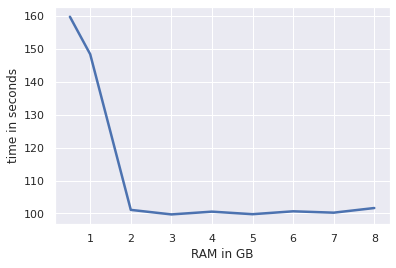

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
# Apply the default theme
sns.set_theme()

resultsRam = benchmark("RAM", False)
ax = sns.lineplot(data=resultsRam, palette="tab10", linewidth=2.5)
ax.set(xlabel='RAM in GB', ylabel='time in seconds')
plt.show()


Measure...
Measure...
Measure...
Measure...


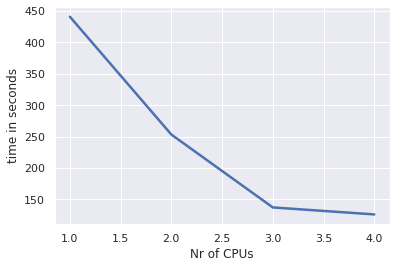

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
# Apply the default theme
sns.set_theme()

resultsCPU = benchmark("CPUs", False)
ax = sns.lineplot(data=resultsCPU, palette="tab10", linewidth=2.5)
ax.set(xlabel='Nr of CPUs', ylabel='time in seconds')
plt.show()


Measure...
Measure...
Measure...
Measure...
Measure...
Measure...
Measure...
Measure...


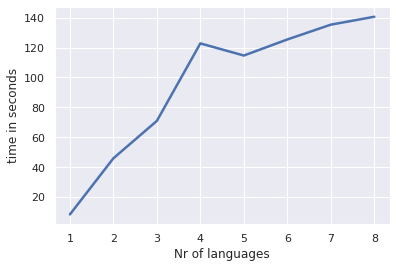

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
# Apply the default theme
sns.set_theme()

resultsTextFiles = benchmark("nrLanguages", False)
ax = sns.lineplot(data=resultsTextFiles, palette="tab10", linewidth=2.5)
ax.set(xlabel='Nr of languages', ylabel='time in seconds')
plt.show()
